In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

plt.style.use('seaborn-darkgrid')
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


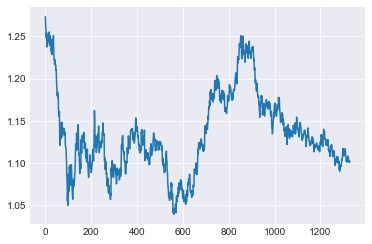

In [2]:
eur_usd = pd.read_csv("./my_EUR_USD_Hdata.csv")
# print(data)
data=eur_usd.as_matrix(columns=['Price'])
price=np.reshape(data,1329)
plt.plot(price)


# Applying Augmented Dickey fuller test to EUR_USD data

In [3]:
from statsmodels.tsa.stattools import adfuller
X = eur_usd['Price'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.193092
p-value: 0.020388
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


results show that we can reject null hypothesis and claim the series is stationary 

# Plotting Auto correlation fuction of the time series

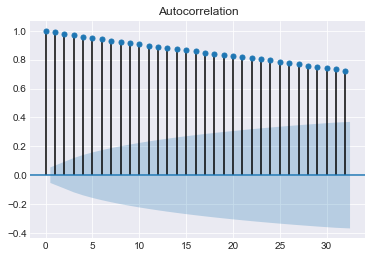

In [4]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(eur_usd['Price'])
pyplot.show()

# Plotting partial auto correlation fuction of the time series

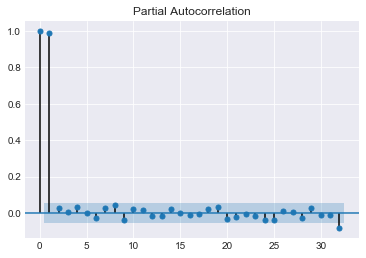

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(eur_usd['Price'])
pyplot.show()

### These plots show that an AR(2) model (auto regressive model with 2 lags) is appropriate for this series but just to experiment we will try ar(1),ar(2),ar(3) and ar(4)

# Building AR(1) model 

In [6]:
with pm.Model() as arprice:
#choosing normal distribution with mean 0 and variance 1 as a prior because beta can only be between -1 and +1 
#else the time series isn't stationary 
    beta = pm.Normal('beta',  mu=0, sigma=1.0)
    likelhood = pm.AR('price', beta, sigma=1.0, observed=X)

In [7]:
with arprice:
    trace = pm.sample(2000, tune=4000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:20<00:00, 1182.54draws/s]


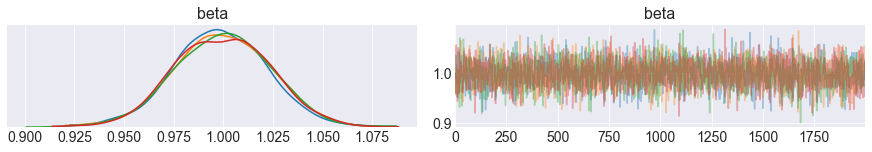

In [8]:
az.plot_trace(trace);

# Testing AR(1) accuracy

In [9]:
eur_usdt = pd.read_csv("./my_EUR_USD_Tdata.csv")
eur_usdt.head()

,Date,Price,Open,High,Low,Change %,days
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5


In [14]:

eur_usdt['predicted_price_ar1']= ""

eur_usdt['predicted_price_ar1'].iloc[0]= trace['beta'].mean()*eur_usd.iloc[-1]['Price']
for i in  range(1,36):
    eur_usdt['predicted_price_ar1'].iloc[i]= trace['beta'].mean()*eur_usdt.iloc[i-1]['Price']
    
eur_usdt.head()

C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Price,Open,High,Low,Change %,days,predicted_price_ar1
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1,1.10059
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2,1.10679
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3,1.10718
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4,1.10669
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5,1.10928


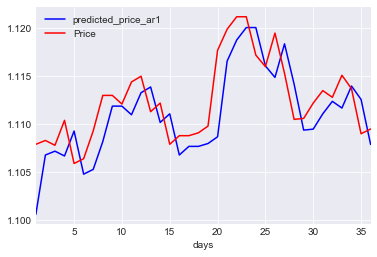

In [15]:
ax = plt.gca()

eur_usdt.plot(kind='line',y='predicted_price_ar1',x='days',color='blue',ax=ax)
eur_usdt.plot(kind='line',y='Price',x='days', color='red', ax=ax)

plt.show()


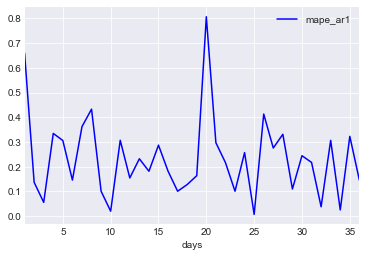

In [18]:
from sklearn.metrics import mean_absolute_error
eur_usdt["mape_ar1"]=""
for i in range(0,36):
    eur_usdt["mape_ar1"].iloc[i]= (abs(eur_usdt['predicted_price_ar1'].iloc[i]-eur_usdt['Price'].iloc[i])/eur_usdt['Price'].iloc[i])*100

    
ax = plt.gca()

eur_usdt.plot(kind='line',y='mape_ar1',x='days',color='blue',ax=ax)
plt.show()


# building AR(2) model

In [19]:
with pm.Model() as arprice:
    beta0 = pm.Normal('beta0', mu=0, sigma=1.0)
    beta1 = pm.Normal('beta1',  mu=0, sigma=1.0)
    likelhood = pm.AR('price', [beta0, beta1], sigma=1.0, observed=X)

In [20]:
with arprice:
    trace = pm.sample(2000, tune=4000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [01:21<00:00, 294.83draws/s]
The acceptance probability does not match the target. It is 0.6917938518557817, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8935538693998641, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


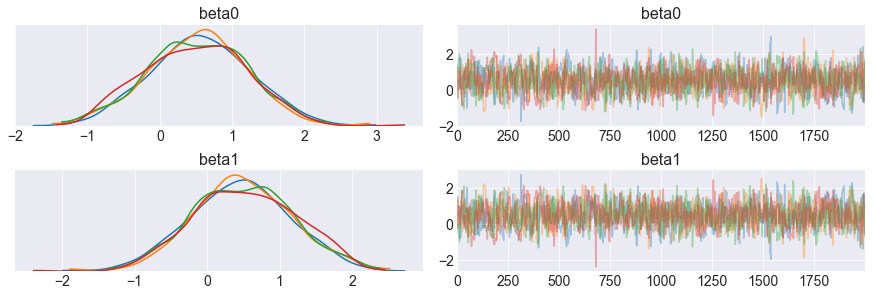

In [21]:
az.plot_trace(trace);

# Testing AR(2) accuracy

In [22]:
eur_usdt['predicted_price_ar2']= ""
eur_usdt['predicted_price_ar2'].iloc[0]= trace['beta0'].mean()*eur_usd.iloc[-1]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']

eur_usdt['predicted_price_ar2'].iloc[1]= trace['beta0'].mean()*eur_usdt.iloc[0]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']

for i in  range(2,36):
    eur_usdt['predicted_price_ar2'].iloc[i]= trace['beta0'].mean()*eur_usdt.iloc[i-1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[i-2]['Price']
    
eur_usdt.head()

C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Price,Open,High,Low,Change %,days,predicted_price_ar1,mape_ar1,predicted_price_ar2
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1,1.10059,0.659669,1.09996
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2,1.10679,0.13667,1.10315
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3,1.10718,0.055526,1.10689
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4,1.10669,0.334529,1.10683
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5,1.10928,0.305884,1.10792


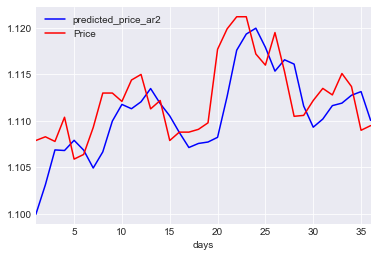

In [23]:
ax = plt.gca()

eur_usdt.plot(kind='line',y='predicted_price_ar2',x='days',color='blue',ax=ax)
eur_usdt.plot(kind='line',y='Price',x='days', color='red', ax=ax)

plt.show()


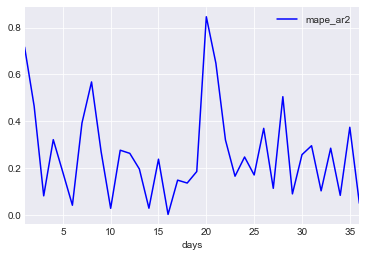

In [25]:
from sklearn.metrics import mean_absolute_error
eur_usdt["mape_ar2"]=""
for i in range(0,36):
    eur_usdt["mape_ar2"].iloc[i]= (abs(eur_usdt['predicted_price_ar2'].iloc[i]-eur_usdt['Price'].iloc[i])/eur_usdt['Price'].iloc[i])*100

    
ax = plt.gca()

eur_usdt.plot(kind='line',y='mape_ar2',x='days',color='blue',ax=ax)
plt.show()


# building AR(3) model

In [26]:
with pm.Model() as arprice:
    beta0 = pm.Normal('beta0', mu=0, sigma=1.0)
    beta1 = pm.Normal('beta1',  mu=0, sigma=1.0)
    beta2 = pm.Normal('beta2',  mu=0, sigma=1.0)
    likelhood = pm.AR('price', [beta0, beta1,beta2], sigma=1.0, observed=X)

In [27]:
with arprice:
    trace = pm.sample(2000, tune=4000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta2, beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [03:15<00:00, 122.57draws/s]


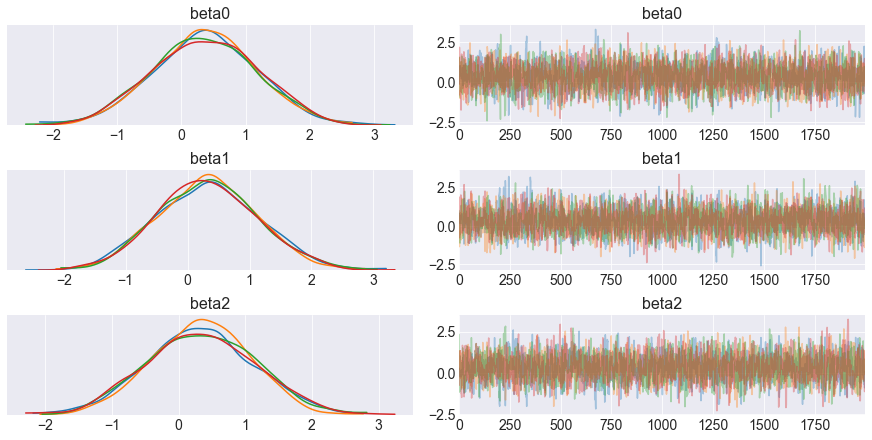

In [28]:
az.plot_trace(trace);

# Testing AR(3) accuracy

In [29]:
eur_usdt['predicted_price_ar3']= ""
eur_usdt['predicted_price_ar3'].iloc[0]= trace['beta0'].mean()*eur_usd.iloc[-1]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']+trace['beta2'].mean()*eur_usd.iloc[-3]['Price']

eur_usdt['predicted_price_ar3'].iloc[1]= trace['beta0'].mean()*eur_usdt.iloc[0]['Price']+trace['beta1'].mean()*eur_usd.iloc[-1]['Price']+trace['beta2'].mean()*eur_usd.iloc[-2]['Price']

eur_usdt['predicted_price_ar3'].iloc[2]= trace['beta0'].mean()*eur_usdt.iloc[1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[0]['Price']+trace['beta2'].mean()*eur_usd.iloc[-1]['Price']

for i in  range(3,36):
    eur_usdt['predicted_price_ar3'].iloc[i]= trace['beta0'].mean()*eur_usdt.iloc[i-1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[i-2]['Price']+trace['beta2'].mean()*eur_usdt.iloc[i-3]['Price']
    
eur_usdt.head()

C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Price,Open,High,Low,Change %,days,predicted_price_ar1,mape_ar1,predicted_price_ar2,mape_ar2,predicted_price_ar3
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1,1.10059,0.659669,1.09996,0.716906,1.10067
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2,1.10679,0.13667,1.10315,0.464974,1.10326
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3,1.10718,0.055526,1.10689,0.0822084,1.10573
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4,1.10669,0.334529,1.10683,0.321876,1.1077
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5,1.10928,0.305884,1.10792,0.182755,1.1086


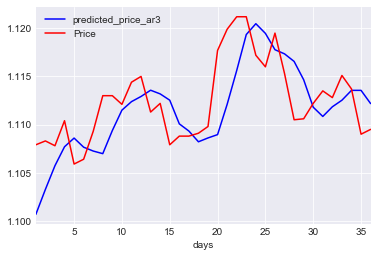

In [30]:
ax = plt.gca()

eur_usdt.plot(kind='line',y='predicted_price_ar3',x='days',color='blue',ax=ax)
eur_usdt.plot(kind='line',y='Price',x='days', color='red', ax=ax)

plt.show()


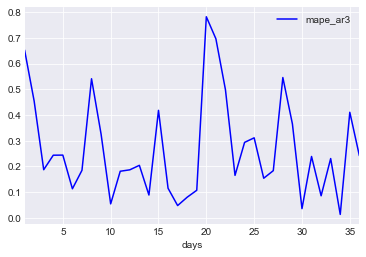

In [31]:
from sklearn.metrics import mean_absolute_error
eur_usdt["mape_ar3"]=""
for i in range(0,36):
    eur_usdt["mape_ar3"].iloc[i]= (abs(eur_usdt['predicted_price_ar3'].iloc[i]-eur_usdt['Price'].iloc[i])/eur_usdt['Price'].iloc[i])*100

    
ax = plt.gca()

eur_usdt.plot(kind='line',y='mape_ar3',x='days',color='blue',ax=ax)
plt.show()


# Building AR(4) model

In [32]:
with pm.Model() as arprice:
    beta0 = pm.Normal('beta0', mu=0, sigma=1.0)
    beta1 = pm.Normal('beta1',  mu=0, sigma=1.0)
    beta2 = pm.Normal('beta2',  mu=0, sigma=1.0)
    beta3 = pm.Normal('beta3',  mu=0, sigma=1.0)
    likelhood = pm.AR('price', [beta0, beta1, beta2, beta3], sigma=1.0, observed=X)

In [33]:
with arprice:
    trace = pm.sample(2000, tune=4000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta3, beta2, beta1, beta0]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [05:30<00:00, 72.53draws/s]


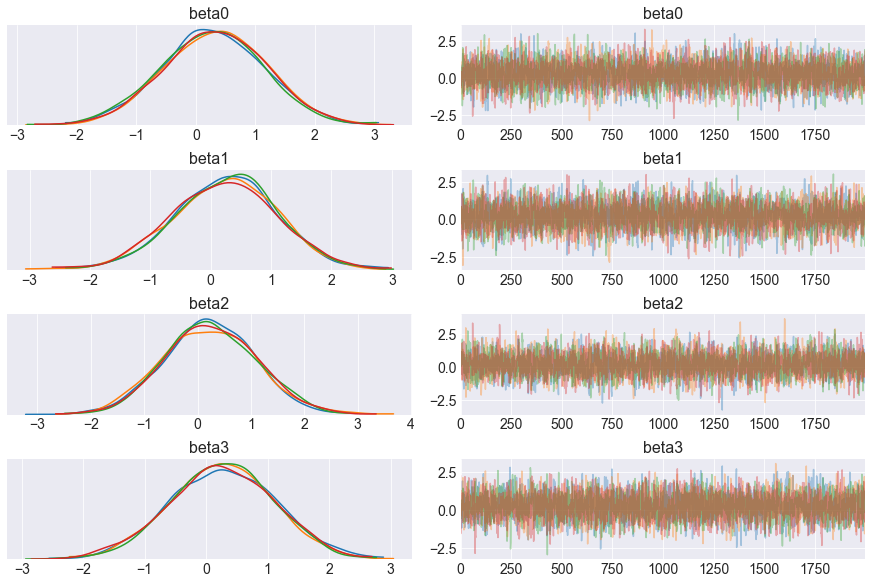

In [34]:
az.plot_trace(trace);

# Testing AR(4) accuracy

In [35]:
eur_usdt['predicted_price_ar4']= ""
eur_usdt['predicted_price_ar4'].iloc[0]= trace['beta0'].mean()*eur_usd.iloc[-1]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']+trace['beta2'].mean()*eur_usd.iloc[-3]['Price']+trace['beta3'].mean()*eur_usd.iloc[-4]['Price']

eur_usdt['predicted_price_ar4'].iloc[1]= trace['beta0'].mean()*eur_usdt.iloc[0]['Price']+trace['beta1'].mean()*eur_usd.iloc[-1]['Price']+trace['beta0'].mean()*eur_usd.iloc[-2]['Price']+trace['beta1'].mean()*eur_usd.iloc[-3]['Price']

eur_usdt['predicted_price_ar4'].iloc[2]= trace['beta0'].mean()*eur_usdt.iloc[1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[0]['Price']+trace['beta0'].mean()*eur_usd.iloc[-1]['Price']+trace['beta1'].mean()*eur_usd.iloc[-2]['Price']

eur_usdt['predicted_price_ar4'].iloc[3]= trace['beta0'].mean()*eur_usdt.iloc[2]['Price']+trace['beta1'].mean()*eur_usdt.iloc[1]['Price']+trace['beta0'].mean()*eur_usdt.iloc[0]['Price']+trace['beta1'].mean()*eur_usd.iloc[-1]['Price']

for i in  range(4,36):
    eur_usdt['predicted_price_ar4'].iloc[i]= trace['beta0'].mean()*eur_usdt.iloc[i-1]['Price']+trace['beta1'].mean()*eur_usdt.iloc[i-2]['Price']+trace['beta2'].mean()*eur_usdt.iloc[i-3]['Price']+trace['beta3'].mean()*eur_usdt.iloc[i-4]['Price']

    
eur_usdt.head()

C:\Users\DELL\Anaconda3\envs\pp\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,Date,Price,Open,High,Low,Change %,days,predicted_price_ar1,mape_ar1,predicted_price_ar2,mape_ar2,predicted_price_ar3,mape_ar3,predicted_price_ar4
0,2-Dec-19,1.1079,1.1014,1.1091,1.1003,0.56%,1,1.10059,0.659669,1.09996,0.716906,1.10067,0.652811,1.10117
1,3-Dec-19,1.1083,1.1079,1.1095,1.1066,0.04%,2,1.10679,0.13667,1.10315,0.464974,1.10326,0.454375,1.1662
2,4-Dec-19,1.1078,1.1082,1.1117,1.1067,-0.05%,3,1.10718,0.055526,1.10689,0.0822084,1.10573,0.187063,1.16811
3,5-Dec-19,1.1104,1.1079,1.1110,1.1078,0.23%,4,1.10669,0.334529,1.10683,0.321876,1.1077,0.24353,1.17014
4,6-Dec-19,1.1059,1.1106,1.1111,1.1040,-0.41%,5,1.10928,0.305884,1.10792,0.182755,1.1086,0.243893,1.10862


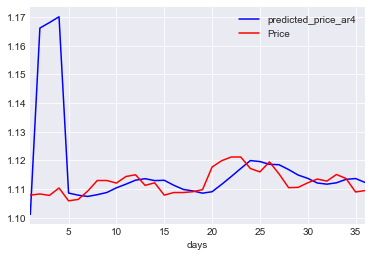

In [36]:
ax = plt.gca()

eur_usdt.plot(kind='line',y='predicted_price_ar4',x='days',color='blue',ax=ax)
eur_usdt.plot(kind='line',y='Price',x='days', color='red', ax=ax)

plt.show()


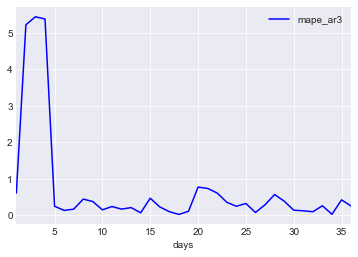

In [37]:
from sklearn.metrics import mean_absolute_error
eur_usdt["mape_ar3"]=""
for i in range(0,36):
    eur_usdt["mape_ar3"].iloc[i]= (abs(eur_usdt['predicted_price_ar4'].iloc[i]-eur_usdt['Price'].iloc[i])/eur_usdt['Price'].iloc[i])*100

    
ax = plt.gca()

eur_usdt.plot(kind='line',y='mape_ar3',x='days',color='blue',ax=ax)
plt.show()


To conclude, experiments ar2,ar3 and ar4 curve keeps getting increasingly smooth and give sufficient results whereas ar1 just returns the previous lag values.